Notebook to analyse how the epidemic has progressed in a single run. Includes geographic spread, network analysis and epi curve

In [2]:
get_ipython().magic('matplotlib inline')

import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
#import seaborn as sns
from collections import defaultdict
import networkx as nx
import os
import json
import numpy as np



In [36]:
dropbox_path = "/Users/s1743989/VirusEvolution Dropbox/Verity Hill/Agent_based_model/"
results_path = "Looping models/Results/Fitted_runs/no_caps/"

# with open(dropbox_path + "Contact_structure/With_ch/hh_clusters.txt") as json_file:
#     hh_clusters = json.load(json_file)
    
    
district_list = ["bo", 'bombali', 'bonthe', 'kailahun', 'kambia', 'kenema', 'koinadugu', 'kono', 'moyamba', 'portloko',
                'pujehun', 'tonkolili', 'westernarearural', 'westernareaurban']

ch_list = ['badjia', 'bagbo', 'bagbwe', 'baoma', 'bumpengawo', 'gbo', 'jaiama-bongor', 'nongobabullom', 'sittia', 'sogbini', 'yawbeko', 'biriwa', 'gbanti-kamaranka', 'gbendembungowahun', 'libeisaygahun', 'magbaimbandorhahun', 'makarigbanti', 'makenicity', 'pakimasabong', 'safrokolimba', 'sandaloko', 'sandatendaren', 'sellalimba', 'tambakka', 'benducha', 'bum', 'dema', 'imperi', 'jong', 'kongbora', 'kori', 'kowa', 'kpangakemo', 'kwamebaikrim', 'lowerbanta', 'ribbi', 'timdale', 'upperbanta', 'dea', 'jawie', 'kissikama', 'kissiteng', 'kissitongi', 'kpejebongre', 'kpejewest', 'luawa', 'malema', 'mandu', 'njaluahun', 'penguia', 'upperbambara', 'yawei', 'bramaia', 'gbinle-dixing', 'magbema', 'mambolo', 'masungbala', 'samu', 'sulima', 'tonkolimba', 'warawarabafodia', 'warawarayagala', 'dama', 'dodo', 'gaura', 'goramamende', 'kandulekpeama', 'kenemacity', 'koya_k', 'langrama', 'malegohun', 'niawa', 'nomo', 'nongowa', 'simbaru', 'smallbo', 'tunkia', 'wandor', 'dembeliasinkunia', 'diang', 'follosabadembelia', 'kasunko', 'malalmara', 'mongo', 'neya', 'nieni', 'sambaya', 'tane', 'yoni', 'fiama', 'gbane', 'gbanekandor', 'gbense', 'goramakono', 'kamara', 'koidu/new', 'lei', 'mafindor', 'nimikoro', 'nimiyama', 'sandor', 'soa', 'tankoro', 'toli', 'bagruwa', 'bumpeh', 'dasse', 'fakunya', 'kagboro', 'kaiyamba', 'kamajei', 'pangakrim', 'pejeh', 'sorogbema', 'sowa', 'bkm', 'buyaromende', 'dibia', 'kaffubullom', 'koya_pl', 'lokomasama', 'maforki', 'marampa', 'masimera', 'sandamagbolontor', 'tms', 'barri', 'gallinasperi', 'kpaka', 'kpanga-kabonde', 'makpele', 'malen', 'manosakrim', 'bocity', 'gbonkolenken', 'kafesimira', 'kakua', 'kalansogoia', 'kholifamabang', 'kolifarowalla', 'komboya', 'kunikebarina', 'kunikesanda', 'lugbu', 'niawalenga', 'selenga', 'tikonko', 'valunia', 'wunde', 'westernarearural', 'westernareaurban']

In [44]:
def prep_single(file_name):

    transmission_dict = {}
    hh_dict = {}
    dist_dict = {}
    dist_present = []
    ch_present = []
    edge_list = []
    case_list = []
    parent_list = []
    hh_set = set()
    ch_dict = {}

    sec_cases = defaultdict(list)
    district_mvmts = defaultdict(list)
    ch_mvmts = defaultdict(list)
    transm_time = {}

    with open(file_name, 'r') as f:
        next(f)
        for l in f: 
            cols = l.strip("\n").split(",")
            case = cols[0]
            parent = cols[1]
            if parent != "NA":
                transmission_dict[case] = parent
                edge_list.append((parent,case))
            elif parent == "NA":
                index_case = case
                index_district = cols[3]
                
            hh_dict[case] = cols[2]
            ch_dict[case] = cols[3]
            dist_dict[case] = cols[4]
            case_list.append(case)
            parent_list.append(parent)
            hh_set.add(cols[2])
            sec_cases[parent].append(case)
            
            transm_time[case] = cols[5]
            
    for item1 in district_list:
        for item2 in district_list:
            if item1 != item2:
                district_mvmts[item1,item2] = []
                
    for item1 in ch_list:
        for item2 in ch_list:
            if item1 != item2:
                ch_mvmts[item1,item2] = []

    for district in dist_dict.values():
        dist_present.append(district)
    for ch in ch_dict.values():
        ch_present.append(ch)

    return [transmission_dict, hh_dict, dist_dict, dist_present, edge_list, case_list, parent_list, hh_set, index_case, index_district, district_mvmts, transm_time, ch_dict, ch_present, ch_mvmts]

In [34]:
def epicurve(file):
    
    len_list = []
    days = []
    day_list = range(0,2000)
    day_dict = defaultdict(list)
    
    count = 0
    count2 = 0
    week_number = 0
    new_cases = 0
    case_list = []
    week_list = []

    with open(file, 'r') as f:
        next(f)
        for l in f:
            tokens = l.strip("\n").split(",")
            person = tokens[0]
            day = int(tokens[5]) #Date of onset
            
            day_dict[day].append(person)
            
    #print(day_dict.keys())

    for item in day_list:
        if item not in day_dict.keys():
            day_dict[item] = []
            
    day_dict[0] = [1]
    
    new_daydict = OrderedDict(sorted(day_dict.items(), key = lambda t:t[0]))
    
    #print(new_daydict)
    
    for k,i in new_daydict.items():
        len_list.append(len(i))
        days.append(k)

    for i in len_list:
        count += 1
        new_cases += i
        if count % 7 == 0:
            case_list.append(new_cases)
            new_cases = 0

    for j in days:
        count2 += 1
        if count2 % 7 == 0:
            week_number += 1
            week_list.append(week_number)

    # print(len(case_list))
    # print(len(week_list))       

    x = week_list[:2500]
    y = case_list[:2500]

    # print(case_list)

    #print(x)
    # plt.plot(x,y)
    
    plt.title("Number of new cases per week")
    plt.xlabel("Week number")
    plt.ylabel("New cases")
    plt.plot(x, y)
    plt.show()   

In [20]:
def dist_jumps(transmission_dict, dist_dict, district_mvmts, transm_time):

    district_jumps = 0

    for case, parent in transmission_dict.items():
        if dist_dict[case] != dist_dict[parent]:
            district_jumps += 1
            district_mvmts[dist_dict[parent], dist_dict[case]].append(transm_time[case])

    return district_jumps, district_mvmts

In [46]:
def ch_jumps(transmission_dict, ch_dict, ch_mvmts, transm_time):

    ch_jumps = 0

    for case, parent in transmission_dict.items():
        if ch_dict[case] != ch_dict[parent]:
            ch_jumps += 1
            ch_mvmts[ch_dict[parent], ch_dict[case]].append(transm_time[case])

    return ch_jumps, ch_mvmts

In [21]:
def hh_jumps(transmission_dict,hh_dict, hh_set):

    hh_jumps = 0

    for case, parent in transmission_dict.items():
        if hh_dict[case] != hh_dict[parent]:
            hh_jumps += 1

    return hh_jumps, len(hh_set)

In [22]:
#cluster jumping
def cluster_mvmt(transmission_dict, hh_dict, hh_clusters):

    cluster_jump = 0
    cluster_num = 1
    within_cluster_jump = 0

    for case, parent in transmission_dict.items():

        if hh_dict[case] not in hh_clusters[hh_dict[parent]] and hh_dict[case] != hh_dict[parent]:
            cluster_jump += 1
            cluster_num += 1
        
        elif hh_dict[case] in hh_clusters[hh_dict[parent]] and hh_dict[case] != hh_dict[parent]:
            within_cluster_jump += 1
            
            
    return int(cluster_jump), int(cluster_num), int(within_cluster_jump)

In [56]:
def chiefdom_dist(ch_present):

    #This isn't working the way it should be in terms of the x axis
    ch_counter = Counter()

    for item in ch_list:
        if item not in ch_present:
            ch_counter[item] = 0

    for place in ch_present:
        ch_counter[place] += 1

    #print(district_counter)

    x = []
    y = []
    
    chiefdoms = list(ch_counter.keys())
    freq = list(ch_counter.values())
    
    index = np.arange(len(chiefdoms))
    
    plt.bar(index, freq)
    plt.xticks(index, chiefdoms, fontsize = 10, rotation = 90)
    
    plt.show()

In [23]:
def district_dist(dist_present):

    #This isn't working the way it should be in terms of the x axis
    district_counter = Counter()

    for item in district_list:
        if item not in dist_present:
            district_counter[item] = 0

    for place in dist_present:
        district_counter[place] += 1

    #print(district_counter)

    x = []
    y = []
    
    districts = list(district_counter.keys())
    freq = list(district_counter.values())
    
    index = np.arange(len(districts))
    
    plt.bar(index, freq)
    plt.xticks(index, districts, fontsize = 10, rotation = 90)
    
    plt.show()

In [24]:
def deg_centr(G):

    D = nx.degree_centrality(G)

    degree_count = Counter()

    for measure in D.values():
        rounded = round(measure, 10)
        degree_count[rounded] += 1

    x = []
    y = []

    for key, value in degree_count.items():
        x.append(key)
        y.append(value)


    plt.scatter(x,y)

    plt.show()

In [25]:
def network(case_list, edge_list):
    
    G = nx.Graph()

    G.add_nodes_from(case_list)
    G.add_edges_from(edge_list)

#     nx.draw(G)
#     plt.savefig("first_network.png")
#     plt.show()
    
    return G

In [58]:
def single_file_analysis(file):

    household_average_calc = []
    index_case_check = []
    index_dist_check = []
    between_cluster_dist = []
    cluster_average = []
    sizes = []
    within_cluster_dist = []

    output = prep_single(file)
    
    if len(output[0]) > 1:
    #print(output)
        #print("New File")
        
        

        district_info = dist_jumps(output[0],output[2], output[10], output[11])
        chiefdom_info = ch_jumps(output[0],output[12], output[14], output[11])
        
        household_jumps = hh_jumps(output[0], output[1], output[7])

        #cluster_jump = cluster_mvmt(output[0], output[1], hh_clusters)


        print("Total cases = " + str(len(output[0]) + 1))
        print("Number of district jumps = " + str(district_info[0]))
        #print("Number of household jumps = " + str(household_jumps[0]))
        print("Number of households involved = " + str(household_jumps[1]))
        print("Number of cases per household = " + str((len(output[0]) + 1) / household_jumps[1]))
        #print("Number of cases per three-hh cluster = " + str((len(output[0]) + 1)/cluster_jump[1]))

        household_average_calc.append((len(output[0]) + 1) / household_jumps[1])

        #between_cluster_dist.append(cluster_jump[0])
        #cluster_average.append((len(output[0]) + 1)/cluster_jump[1])

        #within_cluster_dist.append(cluster_jump[2])

        sizes.append(len(output[0]) + 1)

        distr_dist = district_dist(output[3])
        #ch_dist = chiefdom_dist(output[14])
        #network_output = network(output[5], output[4])
        #centrality  = deg_centr(network_output)

        index_case_check.append(output[8])
        index_dist_check.append(output[9])
        
        epicurve(file)

Total cases = 1864622
Number of district jumps = 326595
Number of households involved = 609740
Number of cases per household = 3.0580608128054583


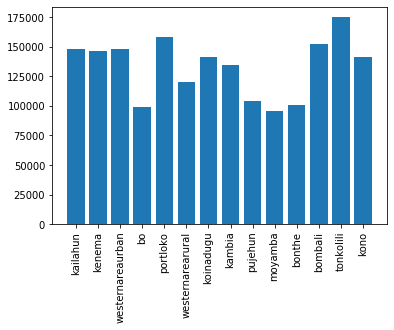

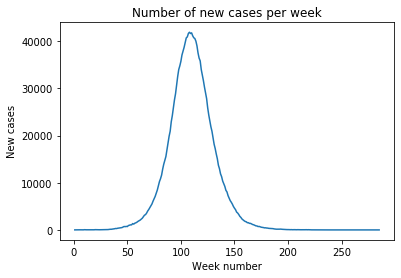

In [59]:
prep_single(dropbox_path + results_path + "1/log_files/information_file_for_50.csv")
single_file_analysis(dropbox_path + results_path + "1/log_files/information_file_for_50.csv")